This notebook conducts the same experiments as in notebook 02, but on v9-v21 and v24 only, as advised by Dr. Saha.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
from IPython.display import display, Markdown

plt.style.use('ggplot')

In [2]:
df = pd.read_excel('adel.xlsx', sheet_name=1, index_col=0)

In [3]:
def get_correlation_indices(df, threshold, cols=None):
    """
    Returns the indices where the Pearson correlation coefficients are
    above the given threshold in the given dataframe.
    """
    pearsonr = np.corrcoef(df, rowvar=False)
    n = len(df.columns)
    indices = np.where(pearsonr.reshape(n ** 2) > threshold)[0]
    
    # The two conditions here make sure we do not include diagonal elements
    # (trivial), and that we include each pair only once.
    indices_2d = [[x // n, x % n] for x in indices if x // n != x % n and x // n < x % n]
    
    # Display the correlations in a matrix to make it look easier
    index = 0
    
    correlation = np.zeros((len(df.columns), len(df.columns)))

    for i in range(n):
        count = 0
        
        if cols is None:
            print('v' + ('0' + str(i+1))[-2:], end=': ')
        else:
            print((' ' + cols[i])[-3:], end=': ')
        for j in range(n):
            if index < len(indices_2d) and i == indices_2d[index][0] \
                and j == indices_2d[index][1] and i < j:
                print('*', end=' ')
                correlation[i][j] = 1
                index += 1
                count += 1
            elif i > j:
                print(' ', end=' ')
            else:
                print('-', end=' ')
        print(' ', count)
    
    return indices_2d, correlation

In [4]:
desired_columns = ['v' + str(x) for x in range(9, 22)]
desired_columns.append('v24')

In [5]:
print(desired_columns)

['v9', 'v10', 'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19', 'v20', 'v21', 'v24']


In [6]:
df = df[desired_columns]

In [7]:
df.head()

,v9,v10,v11,v12,v13,v14,v15,v16,v17,v18,v19,v20,v21,v24
ID,,,,,,,,,,,,,,
1,21,43,16,18.38,20,320.78,17.91,269.87,60.66,19.83,172.13,4.003023,1.00,8
2,35,72,17,18.01,25,472.39,21.73,221.73,58.26,23.83,93.10,0.651049,0.96,9
3,36,68,26,17.28,28,500.05,22.36,256.38,55.42,23.92,113.64,1.475844,1.17,16
4,77,129,28,16.33,36,1218.80,34.91,349.13,87.00,45.40,147.77,0.204385,0.73,24
5,55,94,27,14.61,29,710.74,26.66,225.29,66.68,28.20,92.12,0.387059,0.74,18


In [8]:
df.columns = ['v' + str(i+1) for i, x in enumerate(desired_columns)]

In [9]:
df.head()

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14
ID,,,,,,,,,,,,,,
1,21,43,16,18.38,20,320.78,17.91,269.87,60.66,19.83,172.13,4.003023,1.00,8
2,35,72,17,18.01,25,472.39,21.73,221.73,58.26,23.83,93.10,0.651049,0.96,9
3,36,68,26,17.28,28,500.05,22.36,256.38,55.42,23.92,113.64,1.475844,1.17,16
4,77,129,28,16.33,36,1218.80,34.91,349.13,87.00,45.40,147.77,0.204385,0.73,24
5,55,94,27,14.61,29,710.74,26.66,225.29,66.68,28.20,92.12,0.387059,0.74,18


In [10]:
indices, correlation = get_correlation_indices(df, 0.8)

v01: - * * * * * * * * * - - - -   9
v02:   - * * * * * * * * * - - -   9
v03:     - - * * * * * * - - - -   6
v04:       - * - - * - * - - - -   3
v05:         - - * * * * * - - -   5
v06:           - * * * - - - - *   4
v07:             - * * * - - - -   3
v08:               - * * * - - *   4
v09:                 - * * - - *   3
v10:                   - - - - -   0
v11:                     - - - *   1
v12:                       - - -   0
v13:                         - -   0
v14:                           -   0


In [11]:
def fit_and_display(output, inputs, constant=True, display=True):
    """
    Fits an OLS model with the given output and inputs and shows the
    result summary.
    
    Args:
        output: int, the DV
        inputs: list of int, the IVs. Both args are 1-based indexed.
    """
    Y = df['v' + str(output)]
    X = df[['v' + str(x) for x in inputs]]
    
    if constant:
        X = sm.add_constant(X)
    
    model = sm.OLS(Y, X)
    results = model.fit()
    
    if display:
        print(results.summary())
        
    return results

In [12]:
def print_regression_experiments(output):
    """
    Performs regression by adding variables one by one, with and without the
    constant, and prints a tabular version of the results.
    
    Args:
        output: The output variable
    """
    var_corr = correlation[output - 1]  # Because output is 1-based indexed
    
    # Get correlated IVs
    ivs = np.where(var_corr == 1)[0]
    
    # Convert to 1-based indexing
    ivs += 1
        
    # List of IVs to consider
    considered_ivs = []

    # Print header
    printed = 'Expt. No.|DV |IVs | Adj. R^2|Significant IVs\n---|:---:|:---:|:---:|---\n'
    expt_no = 1

    for i in range(len(ivs)):    
        # First with constant
        printed += str(expt_no) + '|'
        expt_no += 1

        considered_ivs.append(ivs[i])
        result = fit_and_display(output, considered_ivs, display=False)

        # For printing
        print_ivs = ['v' + str(x) for x in considered_ivs]

        # Get metrics
        adj_r2 = result.rsquared_adj
        adj_r2 = int(adj_r2 * 1000) / 1000  # Want only 3 decimal places
        pvalues = np.array(result.pvalues)

        # Add result to Markdown table
        if np.all(pvalues < 0.05):
            printed += ('v' + str(output) + ' |' + ','.join(print_ivs) + '|' + str(adj_r2) + '|All\n')
        else:
            significant = np.where(pvalues < 0.05)[0]
            # [x-1] index is required because here, the constant is the first index.
            printed += ('v' + str(output) + ' |' + ','.join(print_ivs) + '|' + 
                        str(adj_r2) + '|' + ','.join(['v' + str(ivs[x - 1]) for x in significant]) + '\n')

        # Next without constant
        printed += str(expt_no) + '|'
        expt_no += 1

        result = fit_and_display(output, considered_ivs, constant=False, display=False)
        adj_r2 = result.rsquared_adj
        adj_r2 = int(adj_r2 * 1000) / 1000
        pvalues = np.array(result.pvalues)

        if np.all(pvalues < 0.05):
            printed += ('v' + str(output) + ' |' + ','.join(print_ivs) + ' (no const)|' + str(adj_r2) + '|All\n')
        else:
            significant = np.where(pvalues < 0.05)[0]
            printed += ('v' + str(output) + ' |' + ','.join(print_ivs) + ' (no const)|' + str(adj_r2) + '|' + 
                        ','.join(['v' + str(ivs[x]) for x in significant]) + '\n')

    # Print the Markdown
    display(Markdown(printed))

## Experiments

In [13]:
print_regression_experiments(1)

Expt. No.|DV |IVs | Adj. R^2|Significant IVs
---|:---:|:---:|:---:|---
1|v1 |v2|0.94|All
2|v1 |v2 (no const)|0.966|All
3|v1 |v2,v3|0.945|v2,v3
4|v1 |v2,v3 (no const)|0.969|All
5|v1 |v2,v3,v4|0.954|All
6|v1 |v2,v3,v4 (no const)|0.974|All
7|v1 |v2,v3,v4,v5|0.956|v10,v2,v3,v5
8|v1 |v2,v3,v4,v5 (no const)|0.975|v2,v3,v5
9|v1 |v2,v3,v4,v5,v6|0.957|v10,v2,v3,v5
10|v1 |v2,v3,v4,v5,v6 (no const)|0.976|v2,v3,v5,v6
11|v1 |v2,v3,v4,v5,v6,v7|0.961|v2,v3,v5,v6,v7
12|v1 |v2,v3,v4,v5,v6,v7 (no const)|0.978|v2,v3,v5,v6,v7
13|v1 |v2,v3,v4,v5,v6,v7,v8|0.963|v2,v3,v4,v5,v6,v7,v8
14|v1 |v2,v3,v4,v5,v6,v7,v8 (no const)|0.98|All
15|v1 |v2,v3,v4,v5,v6,v7,v8,v9|0.974|v2,v3,v5,v6,v7,v9
16|v1 |v2,v3,v4,v5,v6,v7,v8,v9 (no const)|0.985|v2,v3,v5,v6,v7,v9
17|v1 |v2,v3,v4,v5,v6,v7,v8,v9,v10|0.98|v2,v3,v4,v6,v7,v8,v9,v10
18|v1 |v2,v3,v4,v5,v6,v7,v8,v9,v10 (no const)|0.988|v2,v3,v4,v6,v7,v8,v9,v10


In [29]:
fit_and_display(1, [2, 3, 5, 6, 7, 9], constant=False)

                            OLS Regression Results                            
Dep. Variable:                     v1   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     7123.
Date:                Tue, 20 Nov 2018   Prob (F-statistic):               0.00
Time:                        19:51:29   Log-Likelihood:                -1040.4
No. Observations:                 618   AIC:                             2093.
Df Residuals:                     612   BIC:                             2119.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
v2             0.5551      0.022     25.250      0.0

In [14]:
print_regression_experiments(2)

Expt. No.|DV |IVs | Adj. R^2|Significant IVs
---|:---:|:---:|:---:|---
1|v2 |v3|0.852|All
2|v2 |v3 (no const)|0.911|All
3|v2 |v3,v4|0.88|All
4|v2 |v3,v4 (no const)|0.926|All
5|v2 |v3,v4,v5|0.943|All
6|v2 |v3,v4,v5 (no const)|0.965|All
7|v2 |v3,v4,v5,v6|0.958|v3,v4,v5,v6
8|v2 |v3,v4,v5,v6 (no const)|0.976|All
9|v2 |v3,v4,v5,v6,v7|0.96|v11,v4,v5,v6,v7
10|v2 |v3,v4,v5,v6,v7 (no const)|0.977|v4,v5,v6,v7
11|v2 |v3,v4,v5,v6,v7,v8|0.961|v11,v4,v5,v6,v7,v8
12|v2 |v3,v4,v5,v6,v7,v8 (no const)|0.977|v4,v5,v6,v7,v8
13|v2 |v3,v4,v5,v6,v7,v8,v9|0.98|v11,v3,v5,v6,v7,v8,v9
14|v2 |v3,v4,v5,v6,v7,v8,v9 (no const)|0.988|v3,v5,v6,v7,v8,v9
15|v2 |v3,v4,v5,v6,v7,v8,v9,v10|0.987|All
16|v2 |v3,v4,v5,v6,v7,v8,v9,v10 (no const)|0.992|All
17|v2 |v3,v4,v5,v6,v7,v8,v9,v10,v11|0.987|v11,v3,v4,v6,v7,v8,v9,v10,v11
18|v2 |v3,v4,v5,v6,v7,v8,v9,v10,v11 (no const)|0.992|v3,v4,v6,v7,v8,v9,v10,v11


In [31]:
fit_and_display(2, [3, 5, 6, 7, 8, 9], constant=False)

                            OLS Regression Results                            
Dep. Variable:                     v2   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     8902.
Date:                Tue, 20 Nov 2018   Prob (F-statistic):               0.00
Time:                        19:52:54   Log-Likelihood:                -1355.9
No. Observations:                 618   AIC:                             2724.
Df Residuals:                     612   BIC:                             2750.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
v3             0.5665      0.072      7.841      0.0

In [15]:
print_regression_experiments(3)

Expt. No.|DV |IVs | Adj. R^2|Significant IVs
---|:---:|:---:|:---:|---
1|v3 |v5|0.809|All
2|v3 |v5 (no const)|0.902|All
3|v3 |v5,v6|0.832|All
4|v3 |v5,v6 (no const)|0.905|All
5|v3 |v5,v6,v7|0.936|All
6|v3 |v5,v6,v7 (no const)|0.97|All
7|v3 |v5,v6,v7,v8|0.936|v10,v5,v6,v7
8|v3 |v5,v6,v7,v8 (no const)|0.97|v5,v6,v7
9|v3 |v5,v6,v7,v8,v9|0.938|v10,v5,v6,v7,v9
10|v3 |v5,v6,v7,v8,v9 (no const)|0.971|v5,v6,v7,v9
11|v3 |v5,v6,v7,v8,v9,v10|0.939|v10,v5,v6,v7,v9,v10
12|v3 |v5,v6,v7,v8,v9,v10 (no const)|0.972|v5,v6,v7,v9,v10


In [32]:
fit_and_display(3, [5, 6, 7], constant=False)

                            OLS Regression Results                            
Dep. Variable:                     v3   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     6898.
Date:                Tue, 20 Nov 2018   Prob (F-statistic):               0.00
Time:                        19:58:18   Log-Likelihood:                -1004.4
No. Observations:                 618   AIC:                             2015.
Df Residuals:                     615   BIC:                             2028.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
v5             0.1793      0.023      7.717      0.0

In [16]:
print_regression_experiments(5)

Expt. No.|DV |IVs | Adj. R^2|Significant IVs
---|:---:|:---:|:---:|---
1|v5 |v7|0.809|v7
2|v5 |v7 (no const)|0.901|All
3|v5 |v7,v8|0.842|All
4|v5 |v7,v8 (no const)|0.912|All
5|v5 |v7,v8,v9|0.865|All
6|v5 |v7,v8,v9 (no const)|0.923|All
7|v5 |v7,v8,v9,v10|0.971|v11,v8,v9,v10
8|v5 |v7,v8,v9,v10 (no const)|0.984|All
9|v5 |v7,v8,v9,v10,v11|0.971|v11,v8,v9,v10
10|v5 |v7,v8,v9,v10,v11 (no const)|0.984|v8,v9,v10


In [17]:
print_regression_experiments(6)

Expt. No.|DV |IVs | Adj. R^2|Significant IVs
---|:---:|:---:|:---:|---
1|v6 |v7|0.809|All
2|v6 |v7 (no const)|0.75|All
3|v6 |v7,v8|0.864|All
4|v6 |v7,v8 (no const)|0.864|All
5|v6 |v7,v8,v9|0.865|All
6|v6 |v7,v8,v9 (no const)|0.864|v7,v8
7|v6 |v7,v8,v9,v14|0.891|All
8|v6 |v7,v8,v9,v14 (no const)|0.897|All


In [18]:
print_regression_experiments(8)

Expt. No.|DV |IVs | Adj. R^2|Significant IVs
---|:---:|:---:|:---:|---
1|v8 |v9|0.716|All
2|v8 |v9 (no const)|0.745|All
3|v8 |v9,v10|0.815|All
4|v8 |v9,v10 (no const)|0.807|All
5|v8 |v9,v10,v11|0.892|All
6|v8 |v9,v10,v11 (no const)|0.902|v10,v11
7|v8 |v9,v10,v11,v14|0.908|v14,v10,v11,v14
8|v8 |v9,v10,v11,v14 (no const)|0.922|All


The others may not be worth pursuing, seeing the drop in adj. R^2. Still, have to confirm

In [19]:
print_regression_experiments(4)

Expt. No.|DV |IVs | Adj. R^2|Significant IVs
---|:---:|:---:|:---:|---
1|v4 |v5|0.885|v5
2|v4 |v5 (no const)|0.937|All
3|v4 |v5,v8|0.887|v5,v8
4|v4 |v5,v8 (no const)|0.938|All
5|v4 |v5,v8,v10|0.908|v10,v5,v10
6|v4 |v5,v8,v10 (no const)|0.949|v5,v10


In [20]:
print_regression_experiments(7)

Expt. No.|DV |IVs | Adj. R^2|Significant IVs
---|:---:|:---:|:---:|---
1|v7 |v8|0.761|All
2|v7 |v8 (no const)|0.745|All
3|v7 |v8,v9|0.901|All
4|v7 |v8,v9 (no const)|0.933|All
5|v7 |v8,v9,v10|0.904|All
6|v7 |v8,v9,v10 (no const)|0.942|v9,v10


In [21]:
print_regression_experiments(9)

Expt. No.|DV |IVs | Adj. R^2|Significant IVs
---|:---:|:---:|:---:|---
1|v9 |v10|0.676|All
2|v9 |v10 (no const)|0.809|All
3|v9 |v10,v11|0.768|All
4|v9 |v10,v11 (no const)|0.848|All
5|v9 |v10,v11,v14|0.811|All
6|v9 |v10,v11,v14 (no const)|0.867|All


In [22]:
print_regression_experiments(11)

Expt. No.|DV |IVs | Adj. R^2|Significant IVs
---|:---:|:---:|:---:|---
1|v11 |v14|0.656|All
2|v11 |v14 (no const)|0.693|All


In this subset, does the number of correlations affect the best adj. R^2? Quite probably yes.

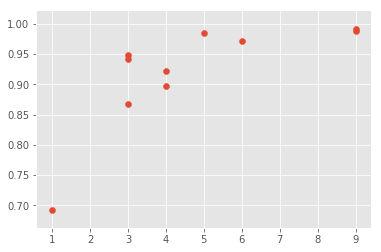

In [23]:
x = [9, 9, 6, 5, 4, 4, 3, 3, 3, 1]
y = [0.988, 0.992, 0.972, 0.984, 0.897, 0.922, 0.949, 0.942, 0.867, 0.693]

plt.scatter(x, y);

In [33]:
np.polyfit(np.log(x), y, 1, full=True)

(array([0.12546518, 0.74665417]),
 array([0.0145646]),
 2,
 array([1.38410577, 0.29026061]),
 2.220446049250313e-15)

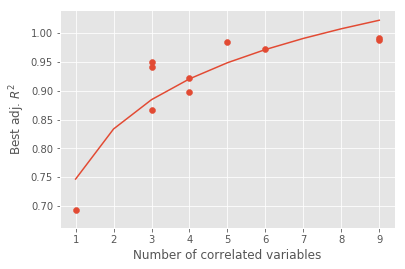

In [25]:
plt.scatter(x, y);

a = range(1, 10)
b = [0.12546518 * np.log(t) + 0.74665417 for t in a]
plt.plot(a, b)

plt.xlabel('Number of correlated variables')
plt.ylabel('Best adj. $R^2$')
plt.show()